In [1]:
import sys
# sys.path.insert(0, '/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP')
import time
import random
import csv
import numpy as np

import scipy.io
from scipy.io import loadmat

import torch
import pickle

from tqdm import tqdm
from tqdm import notebook

import matplotlib
import matplotlib.pyplot as plt

import importlib
import utils

# Enable autoreload
%load_ext autoreload
%autoreload 2
importlib.reload(utils)



TORCH_DTYPE = torch.float64 #NB: Basically all of the matrices in Spatial_GP have 1.e-7 added to the diagonal, to be changed if we want to use float64
torch.set_default_dtype(TORCH_DTYPE)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
torch.set_default_device(device)
print(f'Device is: {device}')

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.cuda.manual_seed_all(0)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False


# with open('data/processed_data.pkl', 'wb') as f:
#     pickle.save(f)

# To compare with samuale use:
# save_pickle('pietro_data', **{'K_pietro':K, 'K_tilde_pietro':K_tilde})    

Using device: cuda:0 (from utils.py)
Using device: cuda:0 (from utils.py)
Device is: cuda:0


## Parameters of the training

In [2]:
rand_xtilde = True # If True, xtilde (inducing points) are chosen randomly, if False, xtilde is chosen from the first ntilde images

cellid  = 8            # Choose cell
ntilde  = 50           # Number of xtilde
additional_x_number = 0 # Additional x points to be added 
kernfun = 'acosker' # Choose kernel function

nEstep      = 10         # Total number of E-steps iterations. Update on the variational parameters m and V, plus the parameters f_param of the link function
nFparamstep = 10         # Number of iterations for the update of the f params of the link function for EACH E-step iteration
nMstep      = 5         # Total number of M-steps iterations. Update on the Hyperparameters of the kernel function
maxiter     = 10         # Iterations of the optimization algorithm comprising M and E steps

ntrain = ntilde # Implement ntrain=-1 to use all the data

## Import the dataset and preprocess 


In [3]:
# Open the .pkl dataset file for reading in binary mode (rb)
with open('/home/idv-eqs8-pza/IDV_code/Variational_GP/spatial_GP/Data/data2_41mixed_tr28.pkl', 'rb') as file:
    # Load the data from the file
    loaded_data = pickle.load(file)
    # loaded_data is a Dataset object from module Data with attributes "images_train, _val, _test" as well as responses

X_train = torch.tensor(loaded_data.images_train).to(device, dtype=TORCH_DTYPE) #shape (2910,108,108,1) where 108 is the number of pixels. 2910 is the amount of training points
X_val   = torch.tensor(loaded_data.images_val).to(device, dtype=TORCH_DTYPE)
X_test  = torch.tensor(loaded_data.images_test).to(device, dtype=TORCH_DTYPE) # shape (30,108,108,1) # nimages, npx, npx

R_train = torch.tensor(loaded_data.responses_train).to(device, dtype=TORCH_DTYPE) #shape (2910,41) 2910 is the amount of training data, 41 is the number of cells
R_val   = torch.tensor(loaded_data.responses_val).to(device, dtype=TORCH_DTYPE)
R_test  = torch.tensor(loaded_data.responses_test).to(device, dtype=TORCH_DTYPE) # shape (30,30,42) 30 repetitions, 30 images, 42 cells

# Create the complete dataset
X = torch.cat( (X_train, X_val), axis=0,) #shape (3160,108,108,1)
R = torch.cat( (R_train, R_val), axis=0,)

n_px_side = X.shape[1]  

# Reshape images to 1D vector and choose a cell
X = torch.reshape(X, ( X.shape[0], X.shape[1]*X.shape[2])) 
R = R[:,cellid] # shape (nt,) where nt is the number of trials

# Choose a random subset of the data and save the idx
all_idx  = torch.arange(0, X.shape[0])                     # Indices of the whole dataset  
torch.manual_seed(0)
torch.cuda.manual_seed(0)
all_idx_perm  = torch.randperm(all_idx.shape[0])                         # Random permutation of the indices

test_1000_idx = all_idx_perm[-1000:]                                     # These will be the indices of the test set
all_idx_perm  = all_idx_perm[~torch.isin( all_idx_perm, test_1000_idx )] # Remove the test set indices from the permutation
rndm_idx      = all_idx_perm[:]                                          # These will be the indices of the training. 

# Choose the indices of the training set. This is overkill here, but in the active learning these indices are constantly changing
in_use_idx    = rndm_idx[:ntrain]
xtilde_idx    = in_use_idx[:ntilde] 
remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )]
# remaining_idx = all_idx_perm[~torch.isin( all_idx_perm, in_use_idx )].sort()[0]

# Set the starting set
xtilde        = X[xtilde_idx,:]                           # In the simplest case the starting points are all inducing points
X_in_use      = X[in_use_idx,:]
X_remaining   = X[remaining_idx,:]
X_test_1000   = X[test_1000_idx,:]

R_remaining   = R[remaining_idx]
R_in_use      = R[in_use_idx]
R_test_1000   = R[test_1000_idx]

# Estimate memory usage
# Calculate memory usage for each tensor
X_memory = X.element_size() * X.nelement()
r_memory = R.element_size() * R.nelement()
# Total memory usage in bytes
total_memory_bytes = X_memory + r_memory
# Convert bytes to megabytes (MB)
total_memory_MB = total_memory_bytes / (1024 ** 2)
print(f'Total dataset memory on GPU: {total_memory_MB:.2f} MB')

Total dataset memory on GPU: 281.23 MB


## Choose starting values of parameters

In [ ]:
torch.set_grad_enabled(False)
# In this code the learnt hyperparameters are the one in the dictionary 'theta'
# One can set them direcly or let generate_theta() set them based on the training set STAs
# To override the choice of generate_theta() just give theta as input 

# If one wants to compare the hyperparemeters set in Matthews's / Samuels's code one has to set
# logbetasam : and transform it to logbetaexpr with the function fromlogbetasam_to_logbetaexpr
# logrhosam  : and transform it to logrhoexpr with the function fromlogrhosam_to_logrhoexpr
# logsigma_0 : and transform it to sigma_0 exponetiating it

# logbetaexpr = utils.fromlogbetasam_to_logbetaexpr( logbetasam=torch.tensor(5.5) )# Logbetaexpr in this code is equal to logbeta in Samuele's code. Samuele's code set logbeta to 5.5
# logrhoexpr  = utils.fromlogrhosam_to_logrhoexpr( logrhosam=torch.tensor(5)) 

# Alternatively one can directly set the hyperparameters to the values in the dictionary 'theta' below
# logbetaexpr = torch.tensor(4.65)
# logrhoexpr = torch.tensor(4.3)

# Or set them as beta and rho
beta = torch.tensor(0.1)
rho  = torch.tensor(0.1)
# beta = torch.tensor(0.022)
# rho  = torch.tensor(0.0045)
logbetaexpr = -2*torch.log(2*beta)
logrhoexpr  = -torch.log(2*rho*rho)

# Samuele's code set the log of sigma
# logsigma_0 = torch.tensor(0) 
# sigma_0    = torch.exp(logsigma_0)
sigma_0 = torch.tensor(1.)

# Amp is not present in Matthews original code
Amp = torch.tensor(1.0) 

# Center of receptive field
# eps_0x = torch.tensor(0.2)
# eps_0y = torch.tensor(-0.02)
eps_0x = torch.tensor(0.0001)
eps_0y = torch.tensor(0.0001)

# Hypermarameters are expected to be 0-dimensional tensors
theta = {'sigma_0'  : sigma_0,     'Amp': Amp,
        'eps_0x'    : eps_0x ,     'eps_0y'   : eps_0y, 
        '-2log2beta': logbetaexpr, '-log2rho2': logrhoexpr }

# Set the gradient of the hyperparemters to be updateable 
for key, value in theta.items():
    # to exclude a single hyperparemeters from the optimization ( to exclude them all just set nMstep=0)
    # if key == 'sigma_0' or key == 'Amp' or key == '-2log2beta' or key == '-log2rho2':
        # continue
    theta[key] = value.requires_grad_()

# Generate the hyperparameters tuple
# If hyperparameters are set manually:
hyperparams_tuple = utils.generate_theta( x=X_in_use, r=R_in_use, n_px_side=n_px_side, display=True, **theta)
# If hyperparameters are set based on the STAs:
# hyperparams_tuple = utils.generate_theta( x=X, r=r, n_px_side=n_px_side, display=True)


A        = torch.tensor(0.01)
logA     = torch.log(A)
# lambda0  = torch.tensor(0.31)
lambda0  = torch.tensor(1.)
# We are not learning the lambda0, since given an A there is a closed form for it that minimised the loss
f_params = {'logA': logA, 'lambda0':lambda0}
f_params['logA'] = f_params['logA'].requires_grad_() 

fit_parameters = {'ntilde':      ntilde,
                  'maxiter':     maxiter,
                  'nMstep':      nMstep,
                  'nEstep':      nEstep,
                  'nFparamstep': nFparamstep,
                  'kernfun':     kernfun,
                  'cellid':      cellid,
                  'n_px_side':   n_px_side,
                  'in_use_idx':  in_use_idx,     # Used idx for generating xtilde, referred to the whole X dataset
                  'xtilde_idx':  xtilde_idx,     # Used idx for generating the complete set, referred to the whole X dataset
                  'start_idx':   in_use_idx }    # Indexes used to generate the initial training set

init_model = {
        'fit_parameters':    fit_parameters,
        'xtilde':            xtilde,
        'hyperparams_tuple': hyperparams_tuple,     # Contains also the upper and lower bounds for the hyperparameters
        'f_params':          f_params,
        # 'm':                 torch.zeros( (ntilde) )
        # 'm': torch.ones( (ntilde) )
        #'V': dont initialize V if you want it to be initialized as K_tilde and projected _exactly_ as K_tilde_b for stabilisation
    }

updated sigma_0 to 1.0000
updated Amp to 1.0000
updated eps_0x to 0.0001
updated eps_0y to 0.0001
updated -2log2beta to 3.2189
updated -log2rho2 to 3.9120


## Fit the model
Also returns a tracking dictionary for important values

Initial Loss: 206.9867
Loss iter 1: 70.7675
 No M-step
Loss iter 2: 69.3329
 No M-step
Loss iter 3: 68.8940
 No M-step
Loss iter 4: 68.7358
 No M-step
Loss iter 5: 68.6763
 No M-step
Loss iter 6: 68.6535
 No M-step
Loss iter 7: 68.6448
 No M-step
Loss iter 8: 68.6414
 No M-step
Loss iter 9: 68.6401

Time spent for E-steps:       1.484s,
Time spent for f params:      1.240s
Time spent for m update:      0.245s
Time spent for M-steps:       0.000s
Time spent for All-steps:     1.485s
Time spent computing Kernels: 0.000s
Time spent computing Loss:    0.019s

Time total after init:        1.518s
Time total before init:       1.600s
Final Loss: 68.6401


 Pietro's model: R2 = 0.47 ± 0.01 Cell: 8 maxiter = 10, nEstep = 10, nMstep = 0 



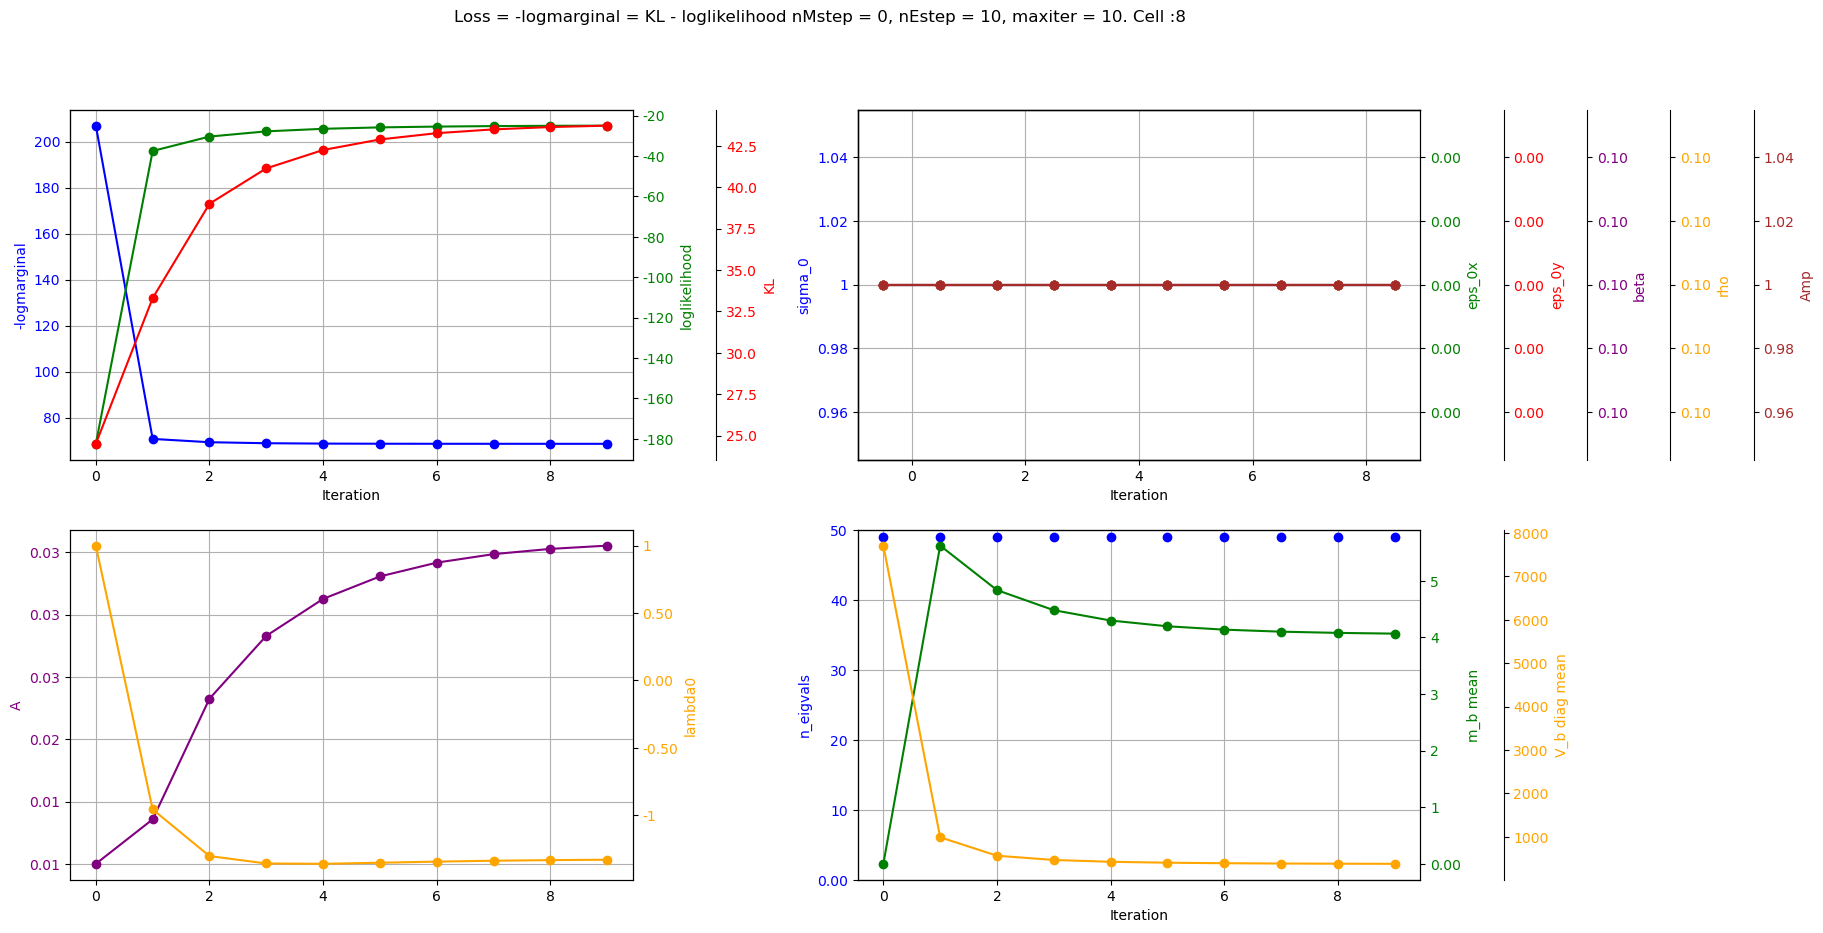

In [5]:
torch.set_grad_enabled(False)
fit_model, err_dict = utils.varGP(X_in_use, R_in_use, **init_model)

if err_dict['is_error']:
    print('Error in the fit')
    raise err_dict['error']

spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X_in_use, at_iteration=None, **fit_model )

xlim = None
# xlim = (0, 10)
ylim_lambda0 = None
ylim_logmarg = None
utils.plot_loss_and_theta_notebook(fit_model, figsize=(15,10), xlim=xlim, ylim_lambda0=ylim_lambda0, marker='o', ylim_logmarg=ylim_logmarg)

### Plot the Loss and Hyperparameters

`VarGP` returns a dictionary with the following structure:

- `fit_parameters`:
  - `maxiter`,
  - `nMstep`,
  - `nEstep`,
  - `kernfun`,
  - `cellid`,
  - `MIN_TOLERANCE`,
  - `EIGVAL_TOL`
  
- `values_track`:
  - `loss_track`:
    - `logmarginal`
    - `loglikelihood`
    - `KL`
  - `theta_track`:
    - `sigma_0`
    - `eps_0x`
    - `eps_0y`
    - `-2log2beta`
    - `-log2rho2`
    - `Amp`
  - `f_par_track`:
    - `logA`
    - `loglambda0`


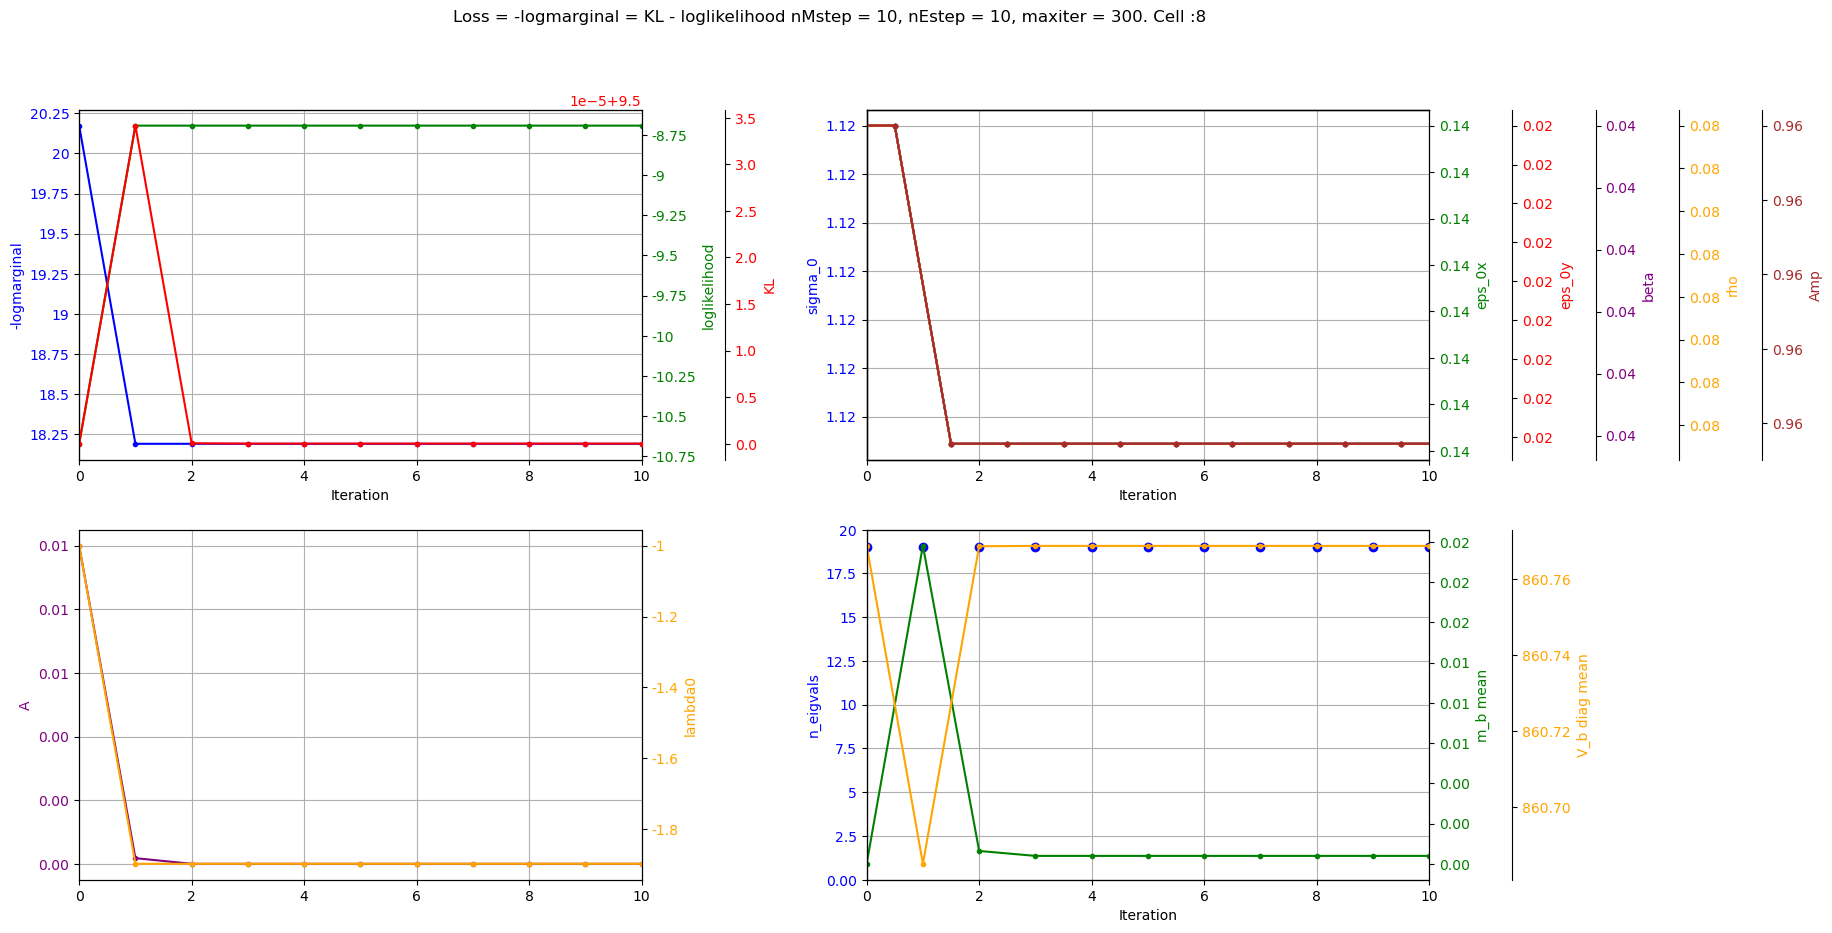

In [6]:
# fit_model = utils.load_model('models/cell8_Problem_ntilde:300_ntot:300_lrfparams:1')
xlim = None
xlim = (0, 10)
ylim_lambda0 = None
utils.plot_loss_and_theta_notebook(fit_model, figsize=(15,10), xlim=xlim, ylim_lambda0=ylim_lambda0, marker='.')#ylim_logmarg=(0, 5000))

### Evaluate the model on the test set using the explained variance and plot it



 Pietro's model: R2 = 0.55 ± 0.03 Cell: 0 maxiter = 10, nEstep = 10, nMstep = 10 



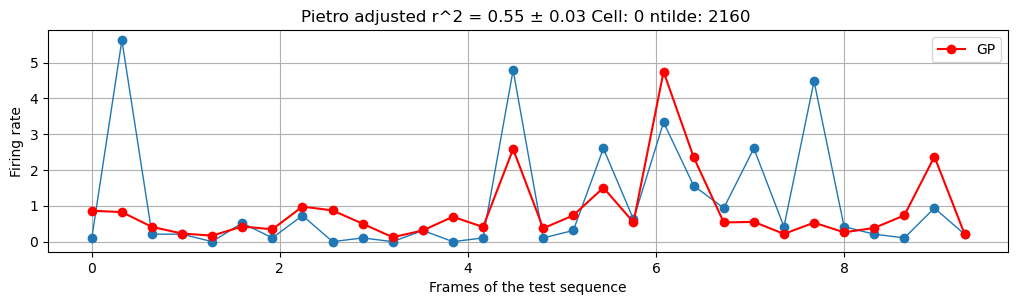

1.5190527144026318


In [16]:
# fit_model = utils.load_model('models/cell8_Problem_learninglambda_adjusted_iterations_ntilde:300_ntot:300_lrfparams:0.1')

# Predict and test
# spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=50, **fit_model )
spk_count_test, spk_count_pred, r2, sigma_r2 = utils.test(X_test, R_test, X_train=X, at_iteration=None, **fit_model )

spk_count_test = spk_count_test.cpu().numpy()
spk_count_pred = spk_count_pred.cpu().numpy()
r2             = r2.cpu().numpy()
sigma_r2       = sigma_r2.cpu().numpy()

spk_count_test = np.mean(spk_count_test, axis=0)

predict_window_ms = 320   # We are predicting the spike count of a 320 ms window ( from +30 to +350 ms since the stimulus onset )
f_rate_test_Hz    = spk_count_test/(predict_window_ms/1000) # Hz
f_rate_pred_Hz    = spk_count_pred/(predict_window_ms/1000) # Hz

# We plot the firing rate of the test set images as if they had been presented as a consetive sequence ( a video ) of one image each 320 ms
dt                = (predict_window_ms/1000)                # sec
time_values       = dt * np.arange( len(spk_count_pred) )   # sec

# Plot results after putting on cpu, numpy.
fig = plt.figure(figsize=(12, 8))
gs  = fig.add_gridspec(5, 5, left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.7)
ax  = fig.add_subplot(gs[3:, :])


ax.plot(time_values, f_rate_test_Hz, 'o-', linewidth=1)
ax.plot(time_values, f_rate_pred_Hz, 'o-', color='red', label='GP')

# ax.errorbar(time_values, f_rate_pred_Hz / 0.05, yerr=np.sqrt(sigma2_f[:,0].cpu()) / 0.05, color='red')
# ax.legend(['data', 'GP'], loc='upper right', fontsize=14)
txt = f'Pietro adjusted r^2 = {r2:.2f} ± {sigma_r2:.2f} Cell: {cellid} ntilde: {ntilde} '
ax.set_title(f'{txt}')
ax.set_ylabel('Firing rate')
ax.set_xlabel('Frames of the test sequence')
ax.grid(axis='both')
# plt.grid()
plt.legend()
plt.show()
plt.close()
print(spk_count_pred.max())